In [1]:
import numpy as np
import numba 
from sysv1_de_config import F_carb
from sysv1_de_config import F_fat
from sysv1_de_config import F_prot
from sysv1_de_config import sigmoid
from input import *
import torch
from local_contributor_config import problem_folder


In [2]:
diet_table_path =r'C:\grlab\data\diet_Mikhail.xlsx'
diet_data = read_diet(diet_table_path)
F_carb_chunks,F_carb = make_Fcarb(diet_data)
F_prot_chunks,F_prot = make_Fprot(diet_data)
F_fat_chunks,F_fat  = make_Ffat(diet_data)

In [3]:

J_s_prot = J_sum(V_total=float(90/60)) # [ммоль/мин]
tau_grid = 0.1
for i in range(len(F_prot_chunks)):
    ch_ = F_prot_chunks[i]
    J_s_prot.add_J_ch(ch_.t1,ch_.t2,delta_t = tau_grid,tau=30.0,T=480.0,rho=ch_.rho,alpha=10.0,volume=1.0)

t_0 = 400
t_end = 1000
N = int((t_end-t_0)/tau_grid)+1
time_grid = np.linspace(start=t_0, stop=t_end, num=N)
J_total = np.zeros(shape=(len(time_grid),),dtype=np.float32)
J_chunks = []
delta_AA = np.zeros(shape=(len(time_grid),),dtype=np.float32)
v_vec = np.zeros(shape=(len(time_grid),),dtype=np.float32)
n_vec = np.zeros(shape=(len(time_grid),),dtype=np.float32)
for i in tqdm(range(len(time_grid))):
    J_s_prot.step(time_grid[i])
    J_total_= J_s_prot.get_J(time_grid[i])
    J_total[i] = J_total_
    delta_AA[i] = - J_s_prot.get_dJdt(time_grid[i])
    # if delta_AA[i] < 1.0 and delta_AA[i] > 0.0:
    #     print(time_grid[i])
J_chunks = np.array(J_chunks)

100%|██████████| 6001/6001 [00:00<00:00, 12810.27it/s]


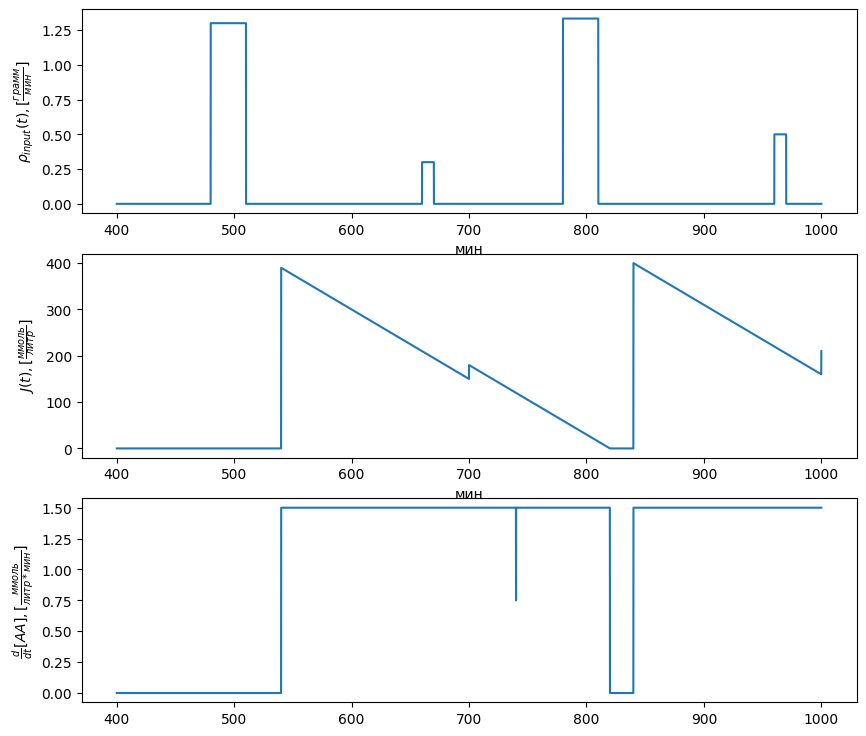

In [7]:
fig,ax = plt.subplots(nrows=3,ncols=1)
fig.set_size_inches(10,9)
ax[0].plot(time_grid,[F_prot(el) for el in time_grid])
ax[0].set_ylabel(r'$\rho_{input}(t),[\frac{грамм}{мин}]$')
ax[0].set_xlabel('мин')
# ax[1].plot(time_grid,itegrate_func(F_prot, time_grid))
# ax[1].set_ylabel(r'$AUC(\rho_{input}),[грамм]$')
# ax[1].set_xlabel('мин')
# ax[2].plot(time_grid,J_total,label= r'$J_{\Sigma}$')
# ax[2].set_ylabel(r'$J(t),[\frac{ммоль}{литр}]$')
# ax[2].set_xlabel('мин')
ax[1].plot(time_grid,J_total,label= r'$J_{\Sigma}$')
ax[1].set_ylabel(r'$J(t),[\frac{ммоль}{литр}]$')
ax[1].set_xlabel('мин')

# for i in range(len(J_chunks[0])):
#     ax[2].plot(time_grid, J_chunks[:,i])

ax[2].plot(time_grid, delta_AA)
ax[2].set_ylabel(r'$\frac{d}{dt}[AA],[\frac{ммоль}{литр*мин}]$')
# ax[4].plot(time_grid, itegrate_arr(delta_AA,time_grid))
# ax[4].set_ylabel(r'$[AA](t),[\frac{ммоль}{литр}]$')

# ax[2].legend()
# ax[0].grid(visible=True, which='both', axis='both')
# ax[1].grid(visible=True, which='both', axis='both')
# ax[2].grid(visible=True, which='both', axis='both')
# ax[3].grid(visible=True, which='both', axis='both')
# ax[4].grid(visible=True, which='both', axis='both')

# ax[0].set_ylim(bottom=0.0)
# ax[1].set_ylim(bottom=0.0)
# ax[2].set_ylim(bottom=0.0)
# ax[2].set_ylim(bottom=0.0)
# ax[3].set_ylim(bottom=0.0)
# ax[4].set_ylim(bottom=0.0)

# ax[0].set_xlim([t_0,t_end])
# ax[1].set_xlim([t_0,t_end])
# ax[2].set_xlim([t_0,t_end])
# ax[3].set_xlim([t_0,t_end])
# ax[4].set_xlim([t_0,t_end])
fig.savefig('tmp_plot.png',dpi=100)


chunk - это $i$-й прием пищи. далее нижний индекс $ch$, принадлежность этому приему пищи, опускаается  
для большинства букв с целью разгрузки записи.  
$a,b$ - начало и конец $i$-го приема пищи.  
$\Delta t$ - малый шаг интегрирования системы.  
$\tau$ - время задержки до начала абсорбции $i$-го приема пищи.  
$T$ - максимальная длительность абсорбции $i$-го приема пищи.  
$\rho$ - скорость поступления пищи. размерность $[\frac{грамм}{мин}]$.  
$V_{total}^{absorbtion}$ - скорость абсорбции для выбранного вещества. размерность $[\frac{ммоль}{литр*мин}]$.  
$V_{ch}^{absorbtion}$ - скорость абсорбции для $i$-го приема пищи. размерность $[\frac{ммоль}{литр*мин}]$.  
скорость абсорбции ограничена, поэтому я ее разделил на число кусочков пищи, абсорбирующихся в текущий момент.  
$\frac{\alpha}{V_{system}}$ - перевод единиц из $[грамм]$ в $[\frac{ммоль}{литр}]$.  
$\alpha = 9.0 [\frac{ммоль}{грамм}]$  
$V_{system}= 1.0 [литр]$  
$\tau=30 [мин]$  
$T = 480 [мин]$  


\begin{equation}
J_{ch}(t) =
    \begin{cases}
      0,t< a   \\
      \frac{\alpha}{V_{system}} \int_{a}^{t}{\rho(t^{'})dt^{'}}, t \in [a,b+\tau] \\
      \max(J_{ch}(t-\Delta t) - V_{ch}^{absorbtion}(t) \Delta t,0),t \in (b+\tau,b+\tau+T] \\
      0, t> b+\tau+T
    \end{cases}
\end{equation}  

$$
V_{ch}^{absorbtion}(t) = \frac{V_{total}^{absorbtion}}{\sum_{i=1}^{N_{chunks}(t)}{[ H(t-(b+\tau))H((b+\tau+T)-t) = 1]}}
$$

перекачка в $[AA]$:
$$
\frac{d}{dt}[AA] = ... - \sum_{i=1}^{N_{chunks}(t)}H(t-(b_{ch}+\tau_{ch}))H((b_{ch}+\tau_{ch}+T_{ch})-t)\frac{d}{dt}{J_{ch}}
$$
в $[AA]$ попадает ровно столько, сколько убыло из $J_{total}$ в момент абсорбции.

In [2]:
tau_grid = 0.1 # [min]
t_0 = 0.0 # [min]
t_end = 6000.0 # [min]


# make input data

diet_table_path =r'C:\grlab\data\diet_Mikhail.xlsx'
diet_data = read_diet(diet_table_path)
F_carb_chunks,F_carb = make_Fcarb(diet_data)
F_prot_chunks,F_prot = make_Fprot(diet_data)
F_fat_chunks,F_fat  = make_Ffat(diet_data)

J_s_prot = J_sum(V_total=float(90/60)) # [ммоль/мин]
for i in range(len(F_prot_chunks)):
    ch_ = F_prot_chunks[i]
    J_s_prot.add_J_ch(ch_.t1,ch_.t2,delta_t = tau_grid,tau=30.0,T=480.0,rho=ch_.rho,alpha=10.0,volume=1.0)

J_s_fat = J_sum(V_total=float(90/60)) # [ммоль/мин]
for i in range(len(F_prot_chunks)):
    ch_ = F_fat_chunks[i]
    J_s_fat.add_J_ch(ch_.t1,ch_.t2,delta_t = tau_grid,tau=30.0,T=480.0,rho=ch_.rho,alpha=10.0,volume=1.0)

J_s_carb = J_sum(V_total=float(90/60)) # [ммоль/мин]
for i in range(len(F_prot_chunks)):
    ch_ = F_carb_chunks[i]
    J_s_carb.add_J_ch(ch_.t1,ch_.t2,delta_t = tau_grid,tau=30.0,T=480.0,rho=ch_.rho,alpha=10.0,volume=1.0)

In [3]:
from local_contributor_config import problem_folder

In [4]:
N = int((t_end-t_0)/tau_grid)+1
time_grid = np.linspace(start=t_0, stop=t_end, num=N)
J_total_AA_ef = np.zeros(shape=(len(time_grid),),dtype=np.float32)
J_total_Glu_ef = np.zeros(shape=(len(time_grid),),dtype=np.float32)
J_total_TG_pl = np.zeros(shape=(len(time_grid),),dtype=np.float32)
ddt_AA_ef = np.zeros(shape=(len(time_grid),),dtype=np.float32)
ddt_Glu_ef = np.zeros(shape=(len(time_grid),),dtype=np.float32)
ddt_TG_pl = np.zeros(shape=(len(time_grid),),dtype=np.float32)
v_vec = np.zeros(shape=(len(time_grid),),dtype=np.float32)
n_vec = np.zeros(shape=(len(time_grid),),dtype=np.float32)
for i in tqdm(range(len(time_grid))):
    # update values
    J_s_prot.step(time_grid[i])
    J_s_fat.step(time_grid[i])
    J_s_carb.step(time_grid[i])
    # get derivations
    J_total_AA_= J_s_prot.get_J(time_grid[i])
    J_total_AA_ef[i] = J_total_AA_
    ddt_AA_ef[i] = - J_s_prot.get_dJdt(time_grid[i])
    ddt_Glu_ef[i] = - J_s_carb.get_dJdt(time_grid[i])
    ddt_TG_pl[i] = - J_s_fat.get_dJdt(time_grid[i])

100%|██████████| 60001/60001 [00:10<00:00, 5626.82it/s]


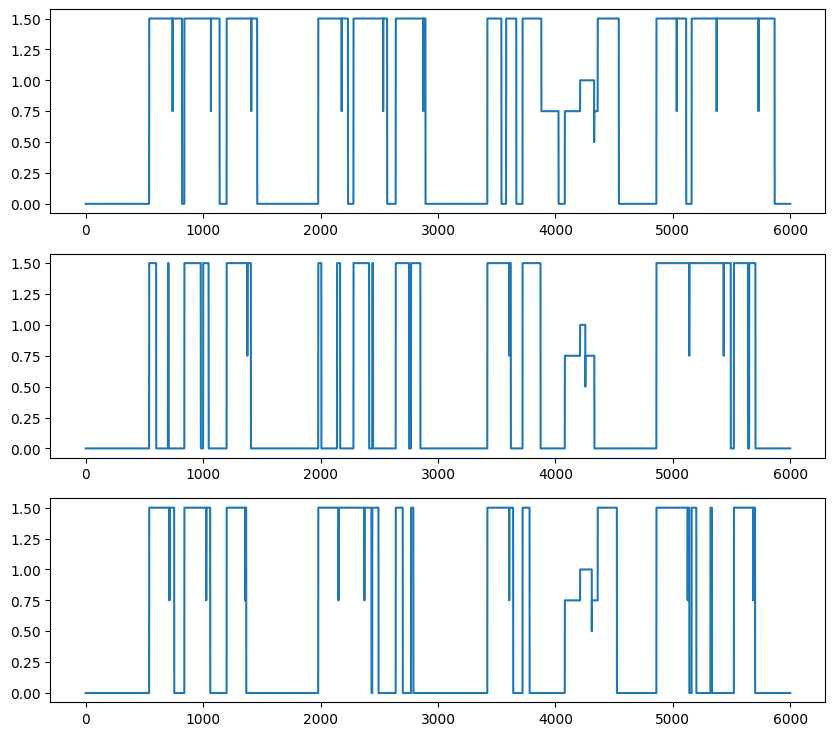

In [5]:
fig,ax = plt.subplots(nrows=3,ncols=1)
fig.set_size_inches(10,9)
ax[0].plot(time_grid,ddt_AA_ef)
ax[1].plot(time_grid,ddt_Glu_ef)
ax[2].plot(time_grid,ddt_TG_pl)

In [6]:
torch.save(
    func_on_linear_grid(tau_grid,t_0,t_end, ddt_AA_ef), 
    os.path.join(problem_folder, 'ddt_AA_ef'))
torch.save(
    func_on_linear_grid(tau_grid,t_0,t_end, ddt_Glu_ef), 
    os.path.join(problem_folder, 'ddt_Glu_ef'))
torch.save(
    func_on_linear_grid(tau_grid,t_0,t_end, ddt_TG_pl), 
    os.path.join(problem_folder, 'ddt_TG_pl'))


In [8]:
ddt_AA_ef

array([-0., -0., -0., ..., -0., -0., -0.], dtype=float32)

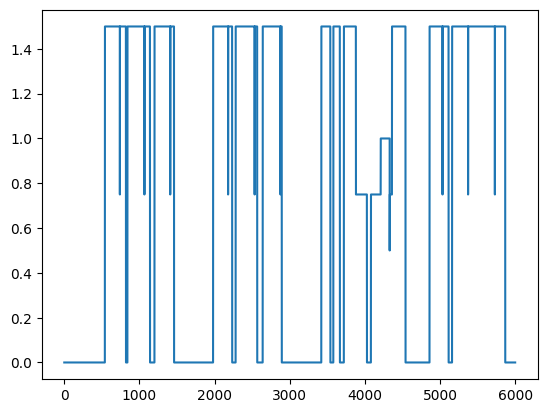

In [10]:
f1 = func_on_linear_grid(tau_grid,t_0,t_end, ddt_AA_ef)
y1 = [f1(t) for t in time_grid]
fig,ax= plt.subplots()
ax.plot(time_grid,y1)